# CSE 144 Spring 2022 Assignment 1

In this assignment, the goal is to build a linear regression model to predict the song popularity based on energy, acoustics, instumentalness, liveness, dancibility, etc. We'll be using the [Song Popularity Dataset](https://www.kaggle.com/datasets/yasserh/song-popularity-dataset) dataset from Kaggle dataset.

In the first section, you'll perform standard data preprocessing using techniques we covered in class. In the second section, you'll train a simple linear regression model.

You should be able to use NumPy, Pandas, and the `train_test_split()` function from scikit-learn to complete everything in this assignment. We also imported Matplotlib for you to visualize the training and validation loss.

Remember that tuning on the test loss is prohibited.

## Rubric

The assignment is worth 57 points in total:
- Data preprocessing (12 points)
    - drop missing values (2 points)
    - drop outliers (5 points)
    - normalization (5 points)
- Dataset split (10 points)
    - test set split (5 points)
    - k-fold train and validation set split (5 points)
- Linear regression (25 points)
    - MSE_loss (3 points)
    - Gradient (5 points)
    - Specify the epoch number and learning rate (0 points)
    - Theta initialization (3 points)
    - Translate dataframe to numpy (3 points)
    - Traininig (5 points)
        - Save train and val loss (2 points)
        - Update parameters (3 points)
    - Find best parameters (3 points)
    - Evaluate on test set (3 points)
    
- Report (10 points, in a separate PDF file)
- Bonus (3 points)
    - If your test loss is below 0.025

In [20]:
!python --version

Python 3.7.13


In [21]:
#Tuple: you can change 
from typing import List, Tuple
#marplotlib is the library for plotting
import matplotlib.pyplot as plt
#one of the fundamental packages for scientific computing contains the ndarray
import numpy as np
#pandas is the python library for data wrangling and analysis DataFrame 
import pandas as pd
#X is the data that is a two dimensional array(matrix), y is the data that is one dimensional arrat(a vector)
from sklearn.model_selection import train_test_split

from tqdm.notebook import trange

import random
seed = 144
random.seed(seed)
np.random.seed(seed)

In [22]:
from google.colab import files
uploaded = files.upload()

Saving song_data.csv to song_data (2).csv


In [23]:
import io
import pandas as pd
df2 = pd.read_csv(io.BytesIO(uploaded['song_data.csv']))
# Dataset is now stored in a Pandas Dataframe

import io for binary data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18835 entries, 0 to 18834
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18714 non-null  float64
 1   song_duration_ms  18717 non-null  float64
 2   acousticness      18717 non-null  float64
 3   danceability      18712 non-null  float64
 4   energy            18697 non-null  float64
 5   instrumentalness  18700 non-null  float64
 6   key               18721 non-null  float64
 7   liveness          18695 non-null  float64
 8   loudness          18716 non-null  float64
 9   audio_mode        18715 non-null  float64
 10  speechiness       18727 non-null  float64
 11  tempo             18715 non-null  float64
 12  audio_valence     18709 non-null  float64
dtypes: float64(13)
memory usage: 2.0 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0f9cabcd0>,
      dtype=object)

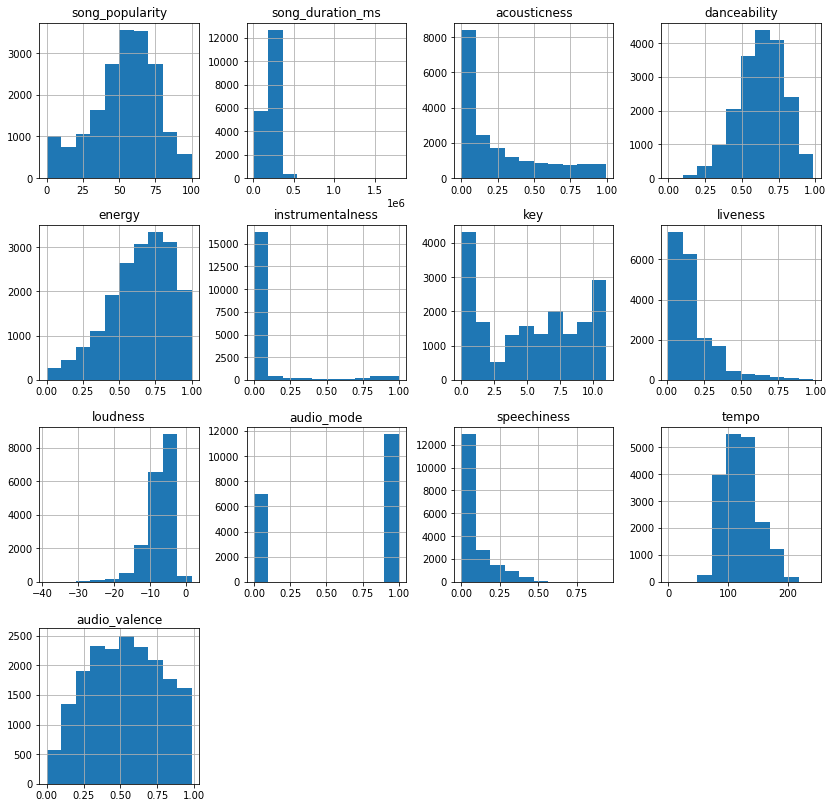

In [24]:
# Load data
df = pd.read_csv("./song_data.csv", index_col=0).drop(["song_name"], axis = 1) #axis = 1 all the row line(가로) add up
# Visualize data 
df.info()
df.hist(figsize=(14,14))

### Data Cleaning
`data.info()` shows that there are some missing values in the dataset. Also, we can see from the histogram that outliers exist for some features. Moreover, the range of different features has a huge gap: most in (0,1), but some are on the order of 1e2, or even 1e5. In the following you need to perform:
1. Drop rows that contain NULL values.
2. Remove outliers for features in ['song_duration_ms', 'instrumentalness'] based on interquantile range.
3. Scale ranges of independent variables using Z-score method, and normalize the range of dependent feature ['song_popularity'] from [0,100] to [0,1]

In [25]:
# drop rows that have NULL value
# ========== YOUR CODE STARTS HERE ==========
#Drop all the rows with any NULL/NAT/NAN values
#data = df.dropna(axis=0, how = 'all', subset=None, inplace=False)
data = df.dropna()
data = data.reset_index(drop=True)

# ========== YOUR CODE ENDS HERE ============
'''
Remove outliers for features in ['song_duration_ms', 'instrumentalness'] 
based on interquantile range. Here for each feature, we first sort data in an ascending order.
Let q1 and q3 be the data that ranks 25% and 75% respectively. We then let iqr = q3 - q1, and 
compute 
                a = q1 - iqr x 1.5,
                b = q3 + iqr x 1.5,
and remove the data out of the range [a, b].
Note: this can be realized with function quantile().
'''
for feature in ['song_duration_ms', 'instrumentalness']:

    # ========== YOUR CODE STARTS HERE ==========
    data = data.sort_values(feature, ascending = True)
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    a = q1 - 1.5*iqr #lowerbound
    b = q3 + 1.5*iqr #upperbound 
    data = data[(data[feature] > a) & (data[feature] < b)]

    # ========== YOUR CODE ENDS HERE ============
data = data.reset_index(drop=True)
'''
Scale all independent features using z-score normalization, and normalize dependent feature range to [0, 1]
Note: use different mean and std for different columns!
'''
# ========== YOUR CODE STARTS HERE ==========
#scale all independent feature using z score normalization, and normalize dependent feature(song_popularity) range to [0,1]
for feature in data.columns:
    #normalize all the feature that is not song_popularity
    if feature != 'song_popularity':
        # (original value - mean of data)/standard deviation of data 
        data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()
#normalize dependent faeture(song_popularity) to [0,1]
data['song_popularity'] = (data['song_popularity'] - min(data['song_popularity'])) / (max(data['song_popularity']) - min(data['song_popularity']))
# ========== YOUR CODE ENDS HERE ============
data

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,audio_valence
0,0.91,-0.686915,0.253264,0.691461,0.484457,-0.349534,0.185625,0.353312,0.652485,0.767237,2.192218,2.058590,1.507623
1,0.37,0.381193,-0.037887,0.919680,0.792608,-0.349534,0.738164,-0.851488,0.300810,-1.303278,-0.379773,0.767026,1.209852
2,0.24,0.381242,-0.185354,1.060639,-0.568392,-0.349534,-0.366913,-0.640509,-0.316890,-1.303278,-0.394635,0.173419,-0.168402
3,0.39,0.382168,-0.706779,1.389543,-0.265377,-0.349534,-1.471991,0.915460,0.748885,0.767237,-0.350050,-0.916949,0.456917
4,0.70,0.382168,-0.748751,1.382831,-0.214018,-0.349534,-1.471991,0.970981,0.704548,0.767237,-0.318469,-0.916984,0.588787
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12927,0.75,-0.844907,1.459463,0.416255,-0.635158,6.426755,1.290702,-0.604421,-0.267850,-1.303278,0.464553,-1.155997,0.669610
12928,0.03,2.457527,-0.901889,0.228310,0.540951,6.426755,1.014433,-0.521140,-0.447550,0.767237,-0.168924,-0.528200,-0.687375
12929,0.75,-0.844907,1.459463,0.416255,-0.635158,6.426755,1.290702,-0.604421,-0.267850,-1.303278,0.464553,-1.155997,0.669610
12930,0.75,-0.844907,1.459463,0.416255,-0.635158,6.426755,1.290702,-0.604421,-0.267850,-1.303278,0.464553,-1.155997,0.669610


Now we visualize the data again.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12932 entries, 0 to 12931
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   12932 non-null  float64
 1   song_duration_ms  12932 non-null  float64
 2   acousticness      12932 non-null  float64
 3   danceability      12932 non-null  float64
 4   energy            12932 non-null  float64
 5   instrumentalness  12932 non-null  float64
 6   key               12932 non-null  float64
 7   liveness          12932 non-null  float64
 8   loudness          12932 non-null  float64
 9   audio_mode        12932 non-null  float64
 10  speechiness       12932 non-null  float64
 11  tempo             12932 non-null  float64
 12  audio_valence     12932 non-null  float64
dtypes: float64(13)
memory usage: 1.3 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0f96ae290>,
      dtype=object)

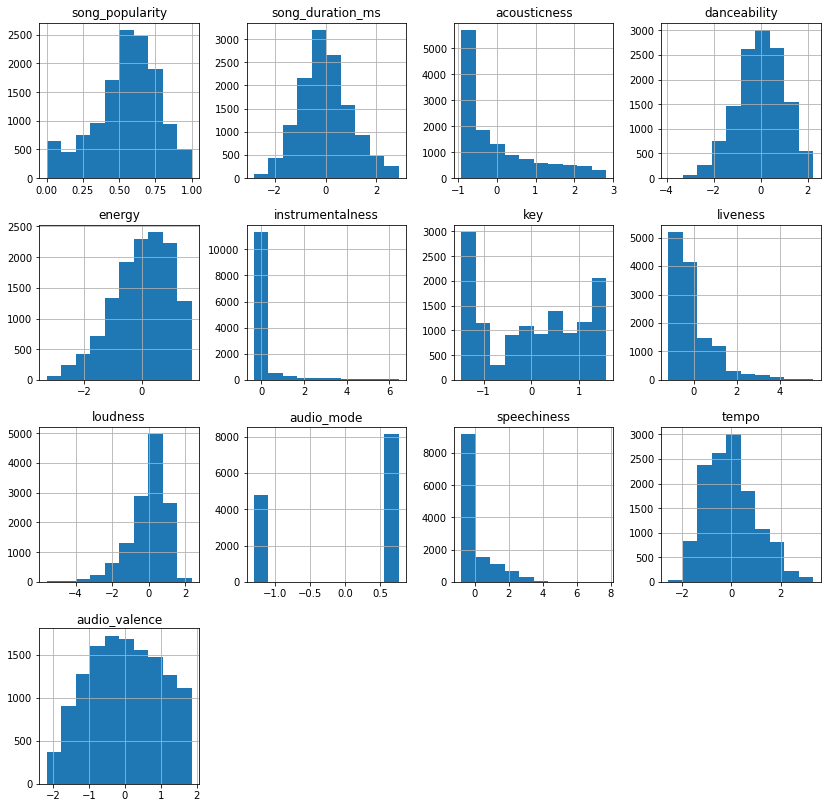

In [26]:
data.info()
data.hist(figsize=(14,14))

## Dataset preparation
Next we will split dataset to train set, validation set and test set. First we randomly choose 30% as test set. Then we use $k$-fold validation on the remaining 70% to generate $k$ different train set and validation set pairs, where $k=5$.

In [27]:
def test_split(data, test_size: float=0.3, seed=seed):
    '''
    train_test_split extracts 75 percents of the rows in the dataset as the training set
    and the remaining 25 percents of the data as the test set
    Use function train_test_split() to split test set.
    '''
    # ========== YOUR CODE STARTS HERE ==========
    #Python iloc() function enables us to select a particular cell of the dataset
    data_X = data.iloc[:,1::] #all the rows and columns except the first(song popularity)
    data_y = data.iloc[:,0:1] #all the rows and labels(song popularity)
    X_train_val, X_test, y_train_val, y_test = train_test_split(data_X, data_y, test_size = test_size, random_state = seed)
    # ========== YOUR CODE ENDS HERE ============
    # print("X_train_val: \n", X_train_val)
    # print("X_test: \n", X_test)
    # print("y_train_val: \n", y_train_val)
    # print("y_test: \n", y_test)
    return (X_train_val.reset_index(drop=True), #default the index
            y_train_val.reset_index(drop=True),
            X_test.reset_index(drop=True),
            y_test.reset_index(drop=True))
    

def train_val_split(X_train_val, y_train_val, k=5, seed=seed):
    '''
    Use given index sets to generate k train and validation pairs. The return value should be 
    a list whose components are tuples:
    [(X_train1, y_train1, X_val1, y_val1), ..., (X_traink, y_traink, X_valk, y_valk)]
    Here suppose data length is 10, the index sets could be like:
                    [[2,5], [1,6], [3,8], [9,4], [0,7]]        
    '''
    # shuffle the dataset randomyly
    index_shuffle = list(X_train_val.index)
    random.shuffle(index_shuffle)
    index_split_list = [[index_shuffle[i+j] for i in range(0, len(index_shuffle), 5)  if i+j<len(index_shuffle)] for j in range(5)]
    train_val_pairs = [(None, None, None, None) for _ in range(k)]
    # ========== YOUR CODE STARTS HERE ==========
    for i in range(k):
      train = pd.DataFrame() #list x_train val = independent variable 
      train_label = pd.DataFrame() #dependent variable 
      val = pd.DataFrame(columns=list(X_train_val))
      val_label = pd.DataFrame()
      for j in range(k): 
        indices = index_split_list[j] #  [[2,5], [1,6], [3,8], [9,4], [0,7]] j = 0 ----> [2, 5]
        if i == j:
          for index in indices:
            val = val.append((X_train_val.iloc[index]), ignore_index=True)
            val_label = val_label.append((y_train_val.iloc[index]), ignore_index=True)
        else:
          for index in indices:
            #train = pd.concat([train, X_train_val.iloc[:32]], ignore_index=True)
            train = train.append((X_train_val.iloc[index]), ignore_index=True)
            train_label = train_label.append((y_train_val.iloc[index]), ignore_index=True)
      train_val_pairs[i] = (train, train_label, val, val_label)    
    # ========== YOUR CODE ENDS HERE ============    
    return train_val_pairs
X_train_val, y_train_val, X_test, y_test = test_split(data)
print("list of X train val",list( X_train_val))
print("list of y train val", list(y_train_val))
train_val_pairs = train_val_split(X_train_val, y_train_val)
#print(train_val_pairs[0].isna().any(axis=None))
print("TRAIN", X_train_val[:2])
print("OURS", train_val_pairs[0][0][:2])
# :O :|


list of X train val ['song_duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode', 'speechiness', 'tempo', 'audio_valence']
list of y train val ['song_popularity']
TRAIN    song_duration_ms  acousticness  danceability    energy  instrumentalness  \
0          1.407803     -0.888617      1.409680 -0.249969         -0.229996   
1          1.628212     -0.917698      0.020228  1.224019         -0.332080   

        key  liveness  loudness  audio_mode  speechiness     tempo  \
0 -1.471991  -1.01805 -0.133494    0.767237    -0.246948 -0.211214   
1  1.290702  -0.54890  1.384387   -1.303278    -0.492165 -1.082664   

   audio_valence  
0       1.622478  
1       1.605462  
OURS    song_duration_ms  acousticness  danceability    energy  instrumentalness  \
0          0.054455     -0.578597      1.530502  0.356061         -0.340983   
1         -0.361372     -0.416006     -0.301964  0.951819         -0.346967   

        key  liv

Final train loss for the best model: 0.1837660522356303
Final validation loss for the best model: 0.18575221950604417
Parameters for the best model: 
 [[ 0.45339326]
 [ 0.08043035]
 [ 0.40101302]
 [ 0.29404897]
 [ 0.28387923]
 [ 0.16610985]
 [ 0.15080198]
 [ 0.11823927]
 [ 0.01710599]
 [ 0.18283374]
 [ 0.28963007]
 [ 0.06313664]
 [-0.12853278]]


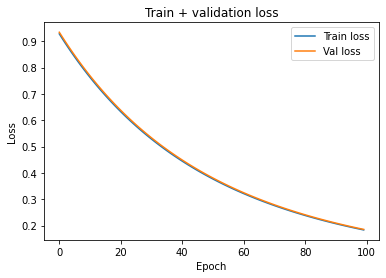

Test loss: song_popularity    0.18089
dtype: float64


In [28]:
def MSE_loss(pred: np.ndarray, target: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    error = pred - target
    squareE = error ** 2
    mseL = squareE.sum()/(2 * len(pred))
    return mseL
    # ========== YOUR CODE ENDS HERE ============ 

def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray):
    # ========== YOUR CODE STARTS HERE ==========
    grad = (X.T) @ (X @ theta - y) / X.shape[0]  # from the piazza
    return grad 
    # ========== YOUR CODE ENDS HERE ============ 

# Specify epoch and learning rate
# ========== YOUR CODE STARTS HERE ==========
num_epochs = 100
learning_rate = 0.01
# ========== YOUR CODE ENDS HERE ============ 
k = 5
train_loss_history = [[] for _ in range(k)]
val_loss_history = [[] for _ in range(k)]

theta_min = None
index_min = None
loss_min = None

for i in range(k):
    X_train, y_train, X_val, y_val = train_val_pairs[i]

    # Translate dataframe to numpy     
    # ========== YOUR CODE STARTS HERE ==========
    X_train, y_train, X_val, y_val = X_train.to_numpy(), y_train.to_numpy(), X_val.to_numpy(), y_val.to_numpy()
    X_train = np.c_[np.ones(len(X_train)), X_train]
    X_val = np.c_[np.ones(len(X_val)), X_val]
    # ========== YOUR CODE ENDS HERE ============
    
    # Initialize theta    
    # ========== YOUR CODE STARTS HERE ==========
    theta = np.random.rand(X_train.shape[1], 1)
    # ========== YOUR CODE ENDS HERE ============

    for epoch in range(num_epochs):
        # Compute loss, and save to train_loss_history and val_loss_history
        # ========== YOUR CODE STARTS HERE ==========
        train_pred = X_train @ theta
        val_pred = X_val @ theta
        train_loss_history[i].append(MSE_loss(train_pred, y_train))
        val_loss_history[i].append(MSE_loss(val_pred, y_val))
        # ========== YOUR CODE ENDS HERE ============

        # Update parameter
        # ========== YOUR CODE STARTS HERE ==========
        theta = theta - learning_rate * gradient(X_train, y_train, theta)
        # ========== YOUR CODE ENDS HERE ============

    
    # Inference on validation set, and find the best parameters. Save corresponding parameters and index in theta_min and  index_min
    # ========== YOUR CODE STARTS HERE ==========
    if i == 0:
        index_min = i
        loss_min = train_loss_history[i][-1]
    else:
        if (train_loss_history[i-1][-1] > train_loss_history[i][-1]).all():
            index_min = i
            loss_min = train_loss_history[i][-1]
            theta_min = theta
    # ========== YOUR CODE ENDS HERE ============

print(f"Final train loss for the best model: {train_loss_history[index_min][-1]}")
print(f"Final validation loss for the best model: {val_loss_history[index_min][-1]}")
print(f"Parameters for the best model: \n {theta_min}")

plt.plot(np.arange(num_epochs), train_loss_history[index_min], label="Train loss")
plt.plot(np.arange(num_epochs), val_loss_history[index_min], label="Val loss")
plt.title("Train + validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Evaluate on test set
# ========== YOUR CODE STARTS HERE ==========
X_test = np.c_[np.ones(len(X_test)), X_test]
test_pred = X_test @ theta_min
test_loss = MSE_loss(test_pred, y_test)
# ========== YOUR CODE ENDS HERE ============       
print(f"Test loss: {test_loss}")          